# Published Items for the Center for Health AI

This takes a list of authors and searches for any items published this year, grabs the proper citation from manubot-cite, and creates a markdown and MS Word document.

This isn't a replacement for a proper data pipeline. Just a demo to see if the selection logic is sound.

- 2021/12/20 First demo (ST)
- 2022/01/18 Fetch pubmed instead of PMC ids (ST)
- 2022/01/19 Added caching to help dev go faster (ST)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import json
import logging
import manubot
import requests
import pandas as pd
import subprocess

from diskcache import Cache
from manubot.cite.citations import Citations
from typing import List, Dict, Union
from datetime import date
from ratelimit import limits, RateLimitException, sleep_and_retry

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

BUILD_FOLDER = "_build"

cache = Cache(BUILD_FOLDER)

<IPython.core.display.Javascript object>

In [3]:
# These can be used as arguments via papermill

# Looking at this year's items
THIS_YEAR = 2021

# If you have an NCBI API key, enter it here
API_KEY = ""

# For testing, set a sample size between 0 and 1.0
SAMPLE_FRACTION = 1.0

# Cache expiration in seconds
CACHE_EXPIRE_SECONDS = 60 * 60 * 24  # seconds * minutes * hours = 1 day

<IPython.core.display.Javascript object>

In [4]:
# We get faster NCBI rates if we use a key.
if API_KEY:
    NCBI_RATE_LIMIT = 10
else:
    NCBI_RATE_LIMIT = 3

NCBI_RATE_LIMIT

10

<IPython.core.display.Javascript object>

In [5]:
# will write out to a folder
if not os.path.exists(BUILD_FOLDER):
    os.makedirs(BUILD_FOLDER)

<IPython.core.display.Javascript object>

In [6]:
# Read in the authors and their specific search terms
authors_df = pd.read_json("authors.json", orient="index")
authors_df

,author_type,search_term
Aquilante C,contributor,(Aquilante C[Author])
Barnes K,contributor,(Barnes K[Author])
Boorgula M,contributor,(Boorgula M[Author])
Brooks I,contributor,(Brooks I[Author])
Campbell M,contributor,(Campbell M[Author])
Casey Greene,pi,(Casey Greene)
Claw K,contributor,(Claw K[Author])
Cohen M,contributor,(Cohen M[Author])
Coors M,contributor,(Coors M[Author])
Crooks K,contributor,(Crooks K[Author])


<IPython.core.display.Javascript object>

In [7]:
# for testing it's nice to take a sample
if 0 < SAMPLE_FRACTION < 1.0:
    authors_df = authors_df.sample(frac=SAMPLE_FRACTION)

<IPython.core.display.Javascript object>

In [8]:
# convert into a dict
author_records = authors_df.to_dict("index")
author_records

{'Aquilante C': {'author_type': 'contributor',
  'search_term': '(Aquilante C[Author])'},
 'Barnes K': {'author_type': 'contributor',
  'search_term': '(Barnes K[Author])'},
 'Boorgula M': {'author_type': 'contributor',
  'search_term': '(Boorgula M[Author])'},
 'Brooks I': {'author_type': 'contributor',
  'search_term': '(Brooks I[Author])'},
 'Campbell M': {'author_type': 'contributor',
  'search_term': '(Campbell M[Author])'},
 'Casey Greene': {'author_type': 'pi', 'search_term': '(Casey Greene)'},
 'Claw K': {'author_type': 'contributor', 'search_term': '(Claw K[Author])'},
 'Cohen M': {'author_type': 'contributor', 'search_term': '(Cohen M[Author])'},
 'Coors M': {'author_type': 'contributor', 'search_term': '(Coors M[Author])'},
 'Crooks K': {'author_type': 'contributor',
  'search_term': '(Crooks K[Author])'},
 'Fingerlin T': {'author_type': 'contributor',
  'search_term': '(Fingerlin T[Author])'},
 'Fishbein L': {'author_type': 'contributor',
  'search_term': '(Fishbein L[Autho

<IPython.core.display.Javascript object>

In [9]:
# modify search terms, e.g., contributors are filtered by CU or CCPM
for k, v in author_records.items():

    # Restrict contributors to CU items
    if v["author_type"] == "contributor":
        v[
            "search_term"
        ] = f"({v['search_term']} AND ((\"University of Colorado\") OR (\"Colorado Center for Personalized Medicine\")))"

author_records

{'Aquilante C': {'author_type': 'contributor',
  'search_term': '((Aquilante C[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Barnes K': {'author_type': 'contributor',
  'search_term': '((Barnes K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Boorgula M': {'author_type': 'contributor',
  'search_term': '((Boorgula M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Brooks I': {'author_type': 'contributor',
  'search_term': '((Brooks I[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Campbell M': {'author_type': 'contributor',
  'search_term': '((Campbell M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Casey Greene': {'author_type': 'pi', 'search_term': '(Casey Greene)'},
 'Claw K': {'author_type': 'contributor',
  'search_term': '((Claw K[Auth

<IPython.core.display.Javascript object>

In [10]:
@sleep_and_retry
@limits(calls=NCBI_RATE_LIMIT, period=60)
def search_ncbi(
    term: str,
    start_year: int,
    api_key: str = None,
    email: str = "Stephen.Taylor@cuanschutz.edu",
) -> List[str]:
    """
    Look up IDs given a search term,
    a beginning year, and an optional API key.

    NCBI asks that we use an API key,
    which increases API calls to 10/minute, instead of 3/minute.

    Returns a list of IDs
    """
    ids = []

    params = {
        "term": term,
        "format": "pmid",
        "tool": "CUAnschutz-Center_for_Health_AI-DEV",
        "email": email,
        "format": "json",
        "retmax": 100,
        "retstart": 0,
        "mindate": f"{start_year}/01/01",
        "maxdate": f"{start_year}/12/31",
    }

    if api_key:
        params["api_key"] = api_key

    # page through the results until there are no more ids
    while True:
        r = requests.get(
            "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", params
        )
        if r.status_code == 200:
            result = r.json()["esearchresult"]
        else:
            logging.error(f"NCBI returned a status code of {r.status_code}.")
            break

        if len(result["idlist"]) == 0:
            # no more IDs
            break
        else:
            # append the IDs to the results...
            ids = ids + result["idlist"]
            # and move the start chunk up by the size of retmax
            params["retstart"] += params["retmax"]

    return ids

<IPython.core.display.Javascript object>

In [11]:
# I would like to do this in parallel, but the deal with NCBI is we agree not to do that
id_dict = {}
for author, v in author_records.items():

    cache_key = f"author-{author}"
    if not cache.get(cache_key):
        logging.info(f"Looking up `{author}` using {v['search_term']}")
        ids = search_ncbi(term=v["search_term"], start_year=THIS_YEAR, api_key=API_KEY)
        cache.set(cache_key, ids, expire=CACHE_EXPIRE_SECONDS)
    else:
        ids = cache[cache_key]

    for id in ids:
        if not id_dict.get(id):
            # create an empty nested dict
            id_dict[id] = {"authors": []}
        id_dict[id]["authors"].append(author)

INFO:root:Looking up `Kudron E` using ((Kudron E[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))


<IPython.core.display.Javascript object>

How many items found?

In [12]:
len(id_dict)

338

<IPython.core.display.Javascript object>

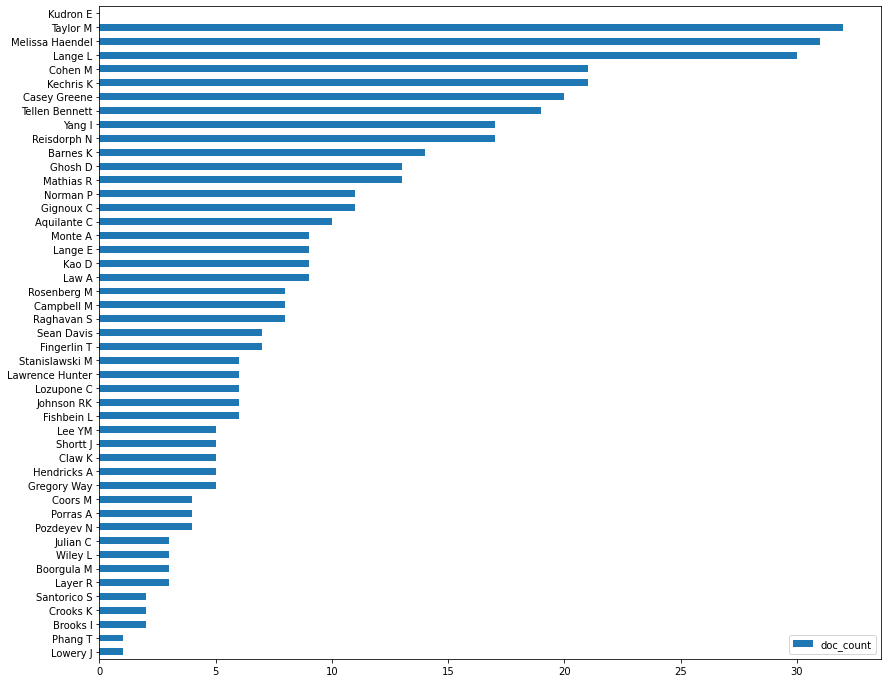

<IPython.core.display.Javascript object>

In [13]:
# useful to get a handle on the shape of the data
doc_count = {}
for k, v in id_dict.items():
    for author in v["authors"]:
        if not doc_count.get(author):
            doc_count[author] = 0
        doc_count[author] += 1

authors_df["doc_count"] = pd.Series(doc_count)
ax = authors_df.sort_values(by="doc_count").plot.barh(figsize=(14, 12))
fig = ax.get_figure()
fig.savefig(os.path.join(BUILD_FOLDER, "author_items.png"))

In [14]:
@sleep_and_retry
@limits(calls=NCBI_RATE_LIMIT, period=60)
def fetch_csljson(id: str) -> Dict:
    """
    Given an ID, fetch the csljson using manubot, which is of course using NCBI, so rate limited.
    """
    logging.info(f"Fetching csljson for {id}")
    citations = Citations([id])
    return citations.get_csl_items()[0]

<IPython.core.display.Javascript object>

In [15]:
# Retrive the csljson from manubot
keys = [k for k in id_dict]

cites = []
for key in keys:
    cache_key = f"csljson-{key}"

    if not cache.get(cache_key):
        csljson = fetch_csljson(key)
        cache.set(cache_key, csljson, expire=CACHE_EXPIRE_SECONDS)
    else:
        csljson = cache[cache_key]

    cites.append(csljson)

<IPython.core.display.Javascript object>

In [16]:
# I'm going to want to sort these later.
for rec in cites:
    key = rec["PMID"]

    id_dict[key]["csljson"] = rec
    id_dict[key]["title"] = rec["title"].strip()

    # all this for the date!
    if rec.get("issued"):
        issued_date_parts = rec["issued"]["date-parts"][0]
        date_str = str(issued_date_parts[0])
        try:
            date_str += f"/{issued_date_parts[1]}"
            try:
                date_str += f"/{issued_date_parts[2]}"
            except:
                pass
        except:
            pass

        id_dict[key]["issued_date"] = date_str

<IPython.core.display.Javascript object>

In [17]:
# sort the dictionary by title
df = pd.DataFrame.from_dict(id_dict, orient="index")
# The filter date in the search isn't necessarily represented in the issue date in the CSLJSON.
df["year"] = THIS_YEAR
df.sort_values(by="title", inplace=True)
df

,authors,csljson,title,issued_date,year
33629880,[Cohen M],"{'title': '""Death Diamond"" Tracing on Thromboe...","""Death Diamond"" Tracing on Thromboelastography...",2021/2/25,2021
34758253,[Melissa Haendel],"{'title': '100,000 Genomes Pilot on Rare-Disea...","100,000 Genomes Pilot on Rare-Disease Diagnosi...",2021/11/11,2021
34245921,[Crooks K],{'title': 'A Curriculum for Genomic Education ...,A Curriculum for Genomic Education of Molecula...,2021/7/7,2021
33960013,[Sean Davis],{'title': 'A Floating Mold Technique for the P...,A Floating Mold Technique for the Programmed A...,2021/5/7,2021
34436483,"[Johnson RK, Kechris K, Yang I]",{'title': 'A Mediation Approach to Discovering...,A Mediation Approach to Discovering Causal Rel...,2021/8/14,2021
...,...,...,...,...,...
34582791,"[Barnes K, Boorgula M, Lange L, Mathias R]",{'title': 'Whole-genome sequencing in diverse ...,Whole-genome sequencing in diverse subjects id...,2021/9/27,2021
34216016,[Taylor M],{'title': 'ZMYND11 variants are a novel cause ...,ZMYND11 variants are a novel cause of centrote...,2021/7/16,2021
33997407,"[Barnes K, Campbell M, Crooks K]",{'title': 'Zika Virus Congenital Syndrome and ...,Zika Virus Congenital Syndrome and,2021/4/22,2021
34428202,[Casey Greene],{'title': 'miQC: An adaptive probabilistic fra...,miQC: An adaptive probabilistic framework for ...,2021/8/24,2021


<IPython.core.display.Javascript object>

In [18]:
@sleep_and_retry
@limits(calls=NCBI_RATE_LIMIT, period=60)
def get_markdown(id: str) -> Dict[str, str]:
    """
    This version gets a single cite per ID.

    Manubot is also calling on NCBI, so rate-limiting applies.
    """
    csl_path = os.path.abspath("manubot-style-title-case.csl")
    csl_path = csl_path.replace("\\", "/")

    logging.info(f"Creating cite reference for {id}")

    # Use manubot-cite to fetch the formatted citation
    args = [
        "manubot",
        "cite",
        "--format=markdown",
        f"--csl={csl_path}",
        id,
    ]

    process = subprocess.run(
        args=args,
        encoding="utf-8",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    assert process.returncode == 0, process.stderr

    return {
        "id": id,
        "cite": process.stdout,
    }

<IPython.core.display.Javascript object>

In [19]:
# create a list of pubmed ids for manubot-cite
ids = [f"pubmed:{id}" for id in df.index.to_list()]

# get cites, admittedly the long way round.
my_list = []
for id in df.index.to_list():
    cache_key = f"md-{id}"

    # look it up in the cache
    if not cache.get(cache_key):
        md = get_markdown(id)
        cache.set(cache_key, md, expire=CACHE_EXPIRE_SECONDS)
    else:
        md = cache[cache_key]

    my_list.append(md)

<IPython.core.display.Javascript object>

Build up the markdown

In [20]:
image_path = os.path.abspath(os.path.join(BUILD_FOLDER, "author_items.png"))

# Windows paths. Switch the slashes over if windows
image_path = image_path.replace("\\", "/")

with open(os.path.join(BUILD_FOLDER, "cites.md"), "w", encoding="utf-8") as f:
    f.write(f"# Center for Health AI, Published Items {THIS_YEAR}\n\n")

    f.write(f"## Author Item Counts\n\n")
    f.write(f"![]({image_path})\n\n")

    f.write(f"## Published Items Citations\n\n")

    # In the custom CSL, I don't include the citation number.
    # This is just a numbered list now.
    for i in range(len(my_list)):
        rec = my_list[i]
        f.write(f"{i+1}. {rec['cite']}")
        f.write("\n")

<IPython.core.display.Javascript object>

In [21]:
# convert markdown to Microsoft Word
args = [
    "pandoc",
    "-s",
    os.path.join(BUILD_FOLDER, "cites.md"),
    "-o",
    os.path.join(BUILD_FOLDER, "cites.docx"),
]

process = subprocess.run(
    args=args,
    encoding="utf-8",
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

assert process.returncode == 0

<IPython.core.display.Javascript object>

In [22]:
cache.close()

<IPython.core.display.Javascript object>